# DDPG - HalfCheetah + pixels & Humanoid

* DDPG - [T. P. Lillicrap et al., "Continuous control with deep reinforcement learning." arXiv preprint arXiv:1509.02971, 2016.](https://arxiv.org/pdf/1509.02971.pdf)
* DPG  - [David Silver et al.. Deterministic Policy Gradient Algorithms. ICML, Jun 2014, Beijing, China](https://inria.hal.science/file/index/docid/938992/filename/dpg-icml2014.pdf)
* BatchNormalization [Sergey Ioffe et al., Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift](https://proceedings.mlr.press/v37/ioffe15.pdf)

## DDPG - Deep Deterministic Policy Gradient

DDPG, short for Deep Deterministic Policy Gradient, is a model-free off-policy actor-critic algorithm, combining DPG with DQN. Recall that [DQN (Deep Q-Network)](https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf) stabilizes the learning of Q-function by experience replay and the frozen target network. The original DQN works in discrete space, and DDPG extends it to continuous space with the actor-critic framework while learning a deterministic policy.

----
#### **DPG refresher**

The DPG algorithm maintains a parameterized actor function $\mu(s|\theta^{\mu})$, which specifies the current policy by deterministically mapping states to a specific action. The critic $Q(s, a)$ is learned using the Bellman equation as in Q-learning. The actor is updated by following the applying the chain rule to the expected return from the start distribution $J$ with respect to the actor parameters

$$ J_\beta(\theta) = \int_\mathcal{S} \rho^\beta Q^\mu(s, \mu_\theta(s)) ds \\
\nabla_\theta J_\beta(\theta) = \mathbb{E}_{s \sim \rho^\beta} [\nabla_a Q^\mu(s, a) \nabla_\theta \mu_\theta(s)  \rvert_{a=\mu_\theta(s)} ] $$

----

In order to do better exploration, an exploration policy $\mu'$ is constructed by adding noise $\mathcal{N}$:

$$ \mu'(s) = \mu_\theta(s) + \mathcal{N} $$

$\mathcal{N}$ can be chosen to suit the environment. The authors used **Ornstein-Uhlenbeck process** to generate temporally correlated exploration.

In addition, DDPG does soft updates (“conservative policy iteration”) on the parameters of both actor and critic, with 
: $\theta’ \leftarrow \tau \theta + (1 - \tau) \theta’$ . In this way, the target network values are constrained to change slowly, different from the design in DQN that the target network stays frozen for some period of time.

One detail in the paper that is particularly useful in robotics is on how to normalize the different physical units of low dimensional features. For example, a model is designed to learn a policy with the robot’s positions and velocities as input; these physical statistics are different by nature and even statistics of the same type may vary a lot across multiple robots. **Batch normalization** is applied to fix it by normalizing every dimension across samples in one minibatch.

<img src="../assets/images/ddpg-algo.png" width="auto" height="auto"/>

### Define Model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import torch.optim as optim
from collections import OrderedDict


# Prioritize device: CUDA > MPS > CPU
def set_device():
    if torch.cuda.is_available():
        DEVICE = torch.device("cuda")
        print("CUDA is available. Using CUDA.")
    elif torch.backends.mps.is_available():
        DEVICE = torch.device("mps")
        print("MPS backend is available. Using MPS.")
    else:
        DEVICE = torch.device("cpu")
        print("Neither CUDA nor MPS is available. Using CPU.")
    return DEVICE

DEVICE = set_device()
# lets see first on cpu
DEVICE = torch.device("cpu")


class CNNBase(nn.Module):
    def __init__(self, num_inputs, features_dim:int=256):
        """CNN similar idea to DQN Nature paper:
        :param num_inputs: Number of input channels (images)
        :param features_dim: Number of features extracted. 
            This corresponds to the number of unit for the last layer.
        """
        super(CNNBase, self).__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(num_inputs, 32, kernel_size=8, stride=4), # next (84-8)/4 + 1 = 20 
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=4, stride=2), # next (20-4)/2 + 1 = 9
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=1), # next (9 - 3)/2 + 1 = 7
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(32*7*7, features_dim),
            nn.ReLU()
        )

        self.feature_dim = features_dim

    def forward(self, observation):
        return self.cnn(observation)

class DummyBase(nn.Module):
    def __init__(self, state_dim):
        super(DummyBase, self).__init__()
        self.feature_dim = state_dim
    
    def forward(self, x):
        return x


class ActorCriticNet(nn.Module):

    def __init__(self, obs_shape, action_size, action_low, action_high, net_arch=dict(), shared_base=True):
        """
        Actor-Critic model for DDPG.
        
        :param obs_shape: Shape of observation space (e.g., (4, 84, 84) or (state_dim,))
        :param action_size: Number of action dimensions.
        :param action_low: Low values of the action.
        :param action_high: High values of the action.
        :param net_arch: Dictionary specifying hidden layers for actor and critic.
                        Example: {"actor": [400, 300], "critic": [400, 300]}
        :param shared_base: Whether the actor and critic share the base network.
        """
        super(ActorCriticNet, self).__init__()

        # Base network selection
        if len(obs_shape) == 3:  # Image input like (4, 84, 84)
            base = CNNBase
        else:
            base = DummyBase

        self.shared_base = shared_base

        if not shared_base:  # Separate networks for actor and critic
            self.actor_base = base(obs_shape[0])
            self.critic_base = base(obs_shape[0])
        else:
            self.base = base(obs_shape[0])
        
        # Action scaling
        self.register_buffer(
            "action_scale", torch.tensor((action_high - action_low) / 2, dtype=torch.float32)
        )
        self.register_buffer(
            "action_bias", torch.tensor((action_high + action_low) / 2, dtype=torch.float32)
        )

        # Actor head
        actor_hidden_layers = net_arch.get("actor", [400, 300])
        self.actor = self._build_mlp(self._get_features_dimension(True), 
            actor_hidden_layers, 
            action_size,
            has_layer_norm=True)

        # Critic head
        critic_hidden_layers = net_arch.get("critic", [400, 300])
        self.critic = self._build_mlp(self._get_features_dimension(False) + action_size,
            critic_hidden_layers, 
            1,
            has_layer_norm=True)
        
        self._initialize_weights()
    
    def _initialize_weights(self):
        """Custom weight initialization for stability."""
        for module in self.modules():
            if isinstance(module, nn.Conv2d):
                init.kaiming_normal_(module.weight, mode='fan_in', nonlinearity='relu')
                if module.bias is not None:
                    init.zeros_(module.bias)
            elif isinstance(module, nn.Linear):
                if module is self.actor[-1]:  # Actor's output layer (pre-tanh)
                    init.xavier_normal_(module.weight)
                    if module.bias is not None:
                        init.zeros_(module.bias)
                elif module is self.critic[-1]:  # Critic's output layer (Q-value)
                    init.xavier_normal_(module.weight, gain=0.01)
                    if module.bias is not None:
                        init.zeros_(module.bias)
                else:  # Hidden layers
                    init.kaiming_normal_(module.weight, mode='fan_in', nonlinearity='relu')
                    if module.bias is not None:
                        init.zeros_(module.bias)

    def _build_mlp(self, input_dim, hidden_layers, output_dim, has_layer_norm=False):
        """Helper function to dynamically create MLPs for actor/critict"""
        if hidden_layers in [None, []]:
            return nn.Identity()
        
        layers = OrderedDict()
        layer_idx = 0
        
        for size in hidden_layers:
            # Add a linear layer
            layers[f"linear_{layer_idx}"] = nn.Linear(input_dim, size)
            layer_idx += 1

            # Optionally add layer normalization - for the actor only
            if has_layer_norm:
                layers[f"layer_norm_{layer_idx}"] = nn.LayerNorm(size)
                layer_idx += 1
                
            # Add activation
            layers[f"relu_{layer_idx}"] = nn.ReLU()    
            layer_idx += 1

            input_dim = size

        # Add the final output layer
        layers[f"linear_{layer_idx}"] = nn.Linear(input_dim, output_dim)

        return nn.Sequential(layers)

    def get_actor_parameters(self):
        """ Return only parameters connected to actor """
        return list(self.actor.parameters()) +\
             list(self.base.parameters() if self.shared_base else self.actor_base.parameters())

    def get_critic_parameters(self):
        """ Return only parameters connected to critic """
        return list(self.critic.parameters()) +\
             list(self.base.parameters() if self.shared_base else self.critic_base.parameters())

    def forward_actor(self, obs):
        """Forward pass for the actor."""
        features = self.base(obs) if self.shared_base else self.actor_base(obs)
        action = F.tanh(self.actor(features))
        return action * self.action_scale + self.action_bias
    
    def forward_critic(self, obs, action):
        """Forward pass for the critic."""
        features = self.base(obs) if self.shared_base else self.critic_base(obs)
        q_value = self.critic(torch.cat([features, action], dim=-1))
        return q_value
    
    def forward(self, obs):
        """
        Joint forward pass for convenience.
        """
        if self.shared_base:
            features = self.base(obs)
            action = F.tanh(self.actor(features))
            action = action * self.action_scale + self.action_bias
            q_value = self.critic(torch.cat([features.detach(), action], dim=-1))
        else: 
            action = self.forward_actor(obs)
            q_value = self.forward_critic(obs, action)
        return action, q_value

    def _get_features_dimension(self, is_actor=True):
        if is_actor:
            return self.base.feature_dim if self.shared_base else self.actor_base.feature_dim
        else:
            return self.base.feature_dim if self.shared_base else self.critic_base.feature_dim

    
    

MPS backend is available. Using MPS.


### OU Noise  

Ornstein-Uhlenbeck process generates temporally correlated exploration, and it effectively copes with physical control problems of inertia.

$$dx_t = \theta(\mu - x_t) dt + \sigma dW_t$$

$$dx_t = \theta(\mu -x_t) dt + \sigma \sqrt dt \cdot  \mathcal{N}(0, 1)$$

$$x_{t+1} = x_t + \theta (\mu - x_t) dt + \sigma \sqrt dt \cdot \mathcal{N}(0, 1)$$

In RL, $dt$ is often removed because: 
* Time steps are fixed and discrete ($dt=1$).
* It simplifies the implementation without significantly affecting behavior.

The simplified OU process becomes:

$$x_{t+1} = x_t + \theta (\mu - x_t) + \sigma \cdot \mathcal{N}(0, 1)$$

- **Key Changes**:
  1. The pull-back force $( \theta (\mu - x_t) )$ is now directly proportional to $\theta$, without being scaled by $dt$.
  2. The noise term $( \sigma \cdot \mathcal{N}(0, 1))$ is not scaled by $\sqrt{dt}$, meaning it directly depends on $\sigma$.

- This still produces noise that:
  - Smoothly transitions over time.
  - Returns to the mean $(\mu)$.
  - Is parameterized by $\theta$ (decay rate) and $ \sigma $ (noise magnitude).




In [2]:
import numpy as np
import copy

class ActionNoise(object):

    def sample(slef):
        pass

    def reset(self):
        pass

#TODO: try when dt = 1 as other case
class OUNoise(ActionNoise):
    """Ornstein-Uhlenbeck process."""
    
    def __init__(self, action_dim, dt=1e-2, mu=0.0, theta=0.15, sigma=0.2):
        self.action_dim = action_dim
        self.mu = mu
        self.dt = dt
        self.theta = theta
        self.sigma = sigma
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = np.ones(self.action_dim) * self.mu
    
    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) * self.dt + self.sigma * np.sqrt(self.dt) * np.random.randn(len(x))
        self.state = x + dx
        return self.state

# https://spinningup.openai.com/en/latest/algorithms/ddpg.html#exploration-vs-exploitation
class NormalActionNoise(ActionNoise):
    """
    Normal or Gaussian noise
    noise∼N(0,σ2)
    """

    def __init__(self, action_dim, scale):
        self.action_dim = action_dim
        self.scale = scale # Standard deviation of the noise
    
    def reset(self):
        pass

    def sample(self):
        #return np.random.normal(self.mu=0, self.scale, size=self.action_dim)
        return np.random.randn(self.action_dim)*self.scale

class DecayingGaussianNoise(ActionNoise):
    """
    Decaying Gausssian Noise
    """
    def __init__(self, action_dim, initial_scale=0.25, final_scale=0.01, decay_rate=1e-4):
        self.action_dim = action_dim
        self.scale = initial_scale
        self.initial_scale = initial_scale
        self.final_scale = final_scale
        self.decay_rate = decay_rate
        self.steps = 0
    
    def reset(self):
        """Reset the internal scale and steps."""
        self.scale = self.initial_scale
        self.steps = 0

    def sample(self):
        # Update noise scale
        self.steps += 1
        current_scale = max(self.final_scale, self.scale * np.exp(-self.decay_rate * self.steps))
        # return np.random.normal(self.mu=0, current_scale, size=self.action_dim)
        return np.random.randn(self.action_dim)*current_scale

class VectorizedActionNoise:
    """
    A Vectorized action noise for parallel environments.

    :param base_noise: Noise generator to use
    :param n_envs: Number of parallel environments
    """

    def __init__(self, base_noise: ActionNoise, n_envs: int) -> None:
        self.base_noise = base_noise
        self.noises = [copy.deepcopy(self.base_noise) for _ in range(n_envs)]

    def reset(self, indices) -> None:
        """
        Reset all the noise processes, or those listed in indices.

        :param indices: The indices to reset. Default: None.
            If the parameter is None, then all processes are reset to their initial position.
        """
        if indices is None:
            indices = range(len(self.noises))

        for index in indices:
            self.noises[index].reset()

    def sample(self) -> np.ndarray:
        """
        Generate and stack the action noise from each noise object.
        """
        noise = np.stack([noise.sample() for noise in self.noises])
        return noise


### Adaptive Parameter Noise 

* [Parameter Space Noise for Exploration 2017/2018](https://arxiv.org/abs/1706.01905)
* https://openai.com/index/better-exploration-with-parameter-noise/

<img src="../assets/images/adaptive-noise.png" width="auto" height="auto"/>

In [3]:
"""
From OpenAI Baselines:
https://github.com/openai/baselines/blob/master/baselines/ddpg/noise.py
"""
class AdaptiveParamNoiseSpec(object):
    def __init__(self, initial_stddev=0.1, desired_action_stddev=0.2, adaptation_coefficient=1.01):
        """
        Note that initial_stddev and current_stddev refer to std of parameter noise, 
        but desired_action_stddev refers to (as name notes) desired std in action space
        """
        self.initial_stddev = initial_stddev
        self.desired_action_stddev = desired_action_stddev
        self.adaptation_coefficient = adaptation_coefficient

        self.current_stddev = initial_stddev

    def adapt(self, distance):
        if distance > self.desired_action_stddev:
            # Decrease stddev.
            self.current_stddev /= self.adaptation_coefficient
        else:
            # Increase stddev.
            self.current_stddev *= self.adaptation_coefficient

    def get_stats(self):
        stats = {
            'param_noise_stddev': self.current_stddev,
        }
        return stats


### Replay Buffer


The replay buffer storage collects and stores the following components for each step  $𝑡$ in a batch of $𝑁$ parallel environments:
- state $s_{t}$
- actions $a_{t}$
- next state $s_{t+1}$
- rewards $r_{t+}$
- dones $m_{t+1}$ - a binary mask to indicate if the environment is done/terminated (0 if active, 1 entered terminal state)
- truncates $tr_{t+1}$ - a binary mask to indicate if the environmnet was truncated due to time limitation (**important to adjust rewards to include next state value**)

At each step $𝑡$, for environment $𝑏$, the collected data is:

$$ \{s_{t,b}, a_{t,b}, r_{t+1,b}, s_{t+1}, d_{t+1,b}, tr_{t+1,b} \} $$

**deque** is very easy to handle once you initialize its maximum length (e.g. deque(maxlen=buffer_size)). However, the indexing operation of deque gets terribly slow as it grows up because it is [internally doubly linked list](https://wiki.python.org/moin/TimeComplexity#collections.deque). On the other hands, list is an array, so it is relatively faster than deque when you sample batches at every step. Its amortized cost of Get item is [O(1)](https://wiki.python.org/moin/TimeComplexity#list).

Last but not least, let's see **numpy.ndarray**. numpy.ndarray is even faster than list due to the fact that it is [a homogeneous array of fixed-size items](https://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.html#numpy.ndarray), so you can get the benefits of [locality of reference](https://en.wikipedia.org/wiki/Locality_of_reference) . Whereas list is an array of pointers to objects, even when all of them are of the same type.

* [OpenAI SpinningUp](https://github.com/openai/spinningup/blob/master/spinup/algos/pytorch/ddpg/ddpg.py)

In [5]:
class ReplayBuffer:
    """    
    Replay buffer used in off-policy algorithms like DDPG/SAC/TD3.
    
    :param obs_dim: Observation dimensions
    :param action_dim: Actions dimensions
    :param n_envs: Number of parallel environments 
    :param size: Max number of elements in the buffer
    :param device: Device (cpu, cuda, ...) on which the code should be run. 
    """
    def __init__(self,
                 obs_dim,
                 action_dim:int =1,
                 n_envs: int = 1,
                 size: int = 1e6,
                 device: torch.device = torch.device("cpu")):
        self.obs_dim = obs_dim
        self.action_dim = action_dim
        self.device = device
        self.n_envs = n_envs

        self.pos = 0
        self.size = 0

        # Adjust buffer size 
        self.max_size = max(int(size // n_envs), 1)

        # Setup the data storage 
        self.obs = np.zeros((self.max_size, self.n_envs, *self.obs_dim), dtype=np.float32)
        self.next_obs = np.zeros((self.max_size, self.n_envs, *self.obs_dim), dtype=np.float32)
        self.actions = np.zeros((self.max_size, self.n_envs, self.action_dim), dtype=np.float32)
        self.rewards = np.zeros((self.max_size, self.n_envs), dtype=np.float32)
        self.terminates = np.zeros((self.max_size, self.n_envs), dtype=np.int8)
        # self.truncates = np.zeros((self.size, self.n_envs), dtype=np.int8)

    def add(self,
            obs: np.ndarray,
            next_obs: np.ndarray,
            action: np.ndarray,
            reward: np.ndarray,
            terminates: np.ndarray
            ):
        self.obs[self.pos] = np.array(obs)
        self.next_obs[self.pos] = np.array(next_obs)
        self.actions[self.pos] = np.array(action)
        self.rewards[self.pos] = np.array(reward)
        self.terminates[self.pos] = np.array(terminates)

        self.pos = (self.pos + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)

    def sample(self,
               batch_size:int = 32):
        """
        Sample elements from the replay buffer.
        
        :param batch_size: Number of elements to sample
        """
        batch_indices = np.random.randint(0, self.size, size=batch_size)
        # Sample randomly the env idx
        env_indices = np.random.randint(0, high=self.n_envs, size=(len(batch_indices),))
        # in the end we return exactly batch_size transitions collected even from different agents
 
        data = dict(
            obs=self.obs[batch_indices, env_indices, :],
            next_obs=self.next_obs[batch_indices, env_indices, :],
            actions=self.actions[batch_indices, env_indices],
            rewards=self.rewards[batch_indices, env_indices],
            # Only use dones that are not due to timeouts
            dones=self.terminates[batch_indices, env_indices]
        )
        return {k: self._to_torch(v) for k,v in data.items()}
        

    def _to_torch(self, data):
        return torch.tensor(data, dtype=torch.float32, device=self.device)
    
    def __len__(self):
        return self.size


### DDPG Agent

In [ ]:
from collections import deque
import gymnasium as gym
import time
import os

from helpers.utils import Logger

class DDPGAgent:
    """
    Deep Deterministic Policy Gradient (DDPG)
    :param env(gym.vector.VectorEnv): Vector Gym Environment to learn from, consists of nEnvs
    :param buffer_size: size of the replay buffer
    :param mini_batch_size: Minibatch size for each gradient update
    :param tau: the soft update coefficient ("Polyak update", between 0 and 1) 
        θ_target = τ*θ_local + (1 - τ)*θ_target
    :param gamma: Discount factor
    :param actor_lr: The learning rate for Actor(policy)
    :param critic_lr: The learning rate for Critic(Q-value)
    :param max_grad_norm: The maximum value for the gradient clipping
    :param clip_value_loss: Whether clip value loss
        This is a parameter specific to the OpenAI implementation. 
    :param device: Device (cpu, cuda, ...) on which the code should be run.
    """
    def __init__(self,
                 env: gym.vector.VectorEnv,
                 buffer_size: int = 1e6,
                 mini_batch_size: int = 128,
                 tau: float = 0.005,
                 action_noise: ActionNoise = None,
                 param_noise: AdaptiveParamNoiseSpec = None,
                 gamma: float = 0.99,
                 actor_lr: float = 1e-4,
                 critic_lr: float = 1e-3,
                 net_arch: dict = dict(),
                 max_grad_norm: float = 0.5,
                 device: torch.device = torch.device("cpu"),
                 reward_to_achieve: int = 2500,
                 learning_starts: int = 10000,
                 share_base: bool = True,
                 has_normalize: bool = True,
                 postfix: str = ""):
        
        self.env = env
        self.n_envs = env.num_envs

        self.mini_batch_size = mini_batch_size
        self.learning_starts = learning_starts

        self.tau = tau
        self.gamma = gamma    
        self.max_grad_norm = max_grad_norm
        self.has_normalize = has_normalize
 
        self.device = device 

        action_size = self.env.action_space.shape[-1] # last element is number of actions can take
        obs_shape = self.env.observation_space.shape[1:] # 0 element is number of envs
        
        action_low = self.env.action_space.low[0]
        action_high = self.env.action_space.high[0]

        # initialize networks
        # Actor Network (w/ Target Network)
        self.actor_critic_local = ActorCriticNet(obs_shape, action_size, action_low, action_high, 
                                                 net_arch, share_base).to(self.device)
        self.actor_critic_target = ActorCriticNet(obs_shape, action_size, action_low, action_high, 
                                                  net_arch, share_base).to(self.device)
        # hard copy the original actor to target actor
        self.actor_critic_target.load_state_dict(self.actor_critic_local.state_dict())

        # initialize optimizers
        self.actor_optimizer = torch.optim.Adam(self.actor_critic_local.get_actor_parameters(), lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.actor_critic_local.get_critic_parameters(), lr=critic_lr)

        if param_noise is not None:
            self.param_noise = param_noise
            self.actor_critic_perturbed =  ActorCriticNet(obs_shape, action_size, action_low, action_high, 
                                                 net_arch, share_base).to(self.device)            
            self.action_noise = None
        else:
            self.param_noise = None
            self.action_noise = action_noise or NormalActionNoise(action_size, 0.2) # try 0.25 as standard scale
            if self.n_envs > 1:
                self.action_noise = VectorizedActionNoise(self.action_noise, self.n_envs)

        # define Replay Memory 
        self.replay_memory = ReplayBuffer(
            obs_shape,
            action_size,
            n_envs=self.n_envs,
            size=buffer_size,
            device=self.device)   

        # --------- Additional Parameters to think about
        self.rollout_steps = 1
        # so epoch is size 100 * 1 * n_env, after this number update param_noise if one is used  

        # logger initialization 
        run_name =(
            f"actor_lr{actor_lr}"
            f"_critic_lr{critic_lr}"
            f"_gamma{gamma}"
            f"_nenvs{env.num_envs}"
            f"_batch{self.mini_batch_size}"
            f"_noise{action_noise.scale if action_noise is not None else 'param'}" 
            f"_{int(time.time())}"
        )

        run_name = "".join(run_name)
        self.logger = Logger(run_name=run_name, env=env.envs[0].spec.id, algo=f"DDPG{postfix}")
        # Log hyperparameters table
        hyperparams = {
            "actor_lr": actor_lr,
            "critic_lr": critic_lr,
            "gamma": gamma,
            "tau": tau,
            "buffer_size": buffer_size,
            "mini_batch_size": mini_batch_size,
            "max_grad_norm": max_grad_norm,
            "action_noise": action_noise.scale if action_noise is not None else "param",
        }
        self.logger.log_hyperparameters(hyperparams)

        self.episode_num = 1
        self.best_reward = float('-inf')
        self.reward_to_achieve = reward_to_achieve 
    
    def collect_rollouts(self):
        """
        Collect experiences and store them into a ``ReplayBuffer``.
        """
        obs = self._last_obs

        for _ in range(self.rollout_steps): # from what I see by default its 1 to 1 for DDPG, 1 step rollouts, 1 step learn 
        
            actions = self.select_action(torch.tensor(obs, dtype=torch.float32, device=self.device)) 

            next_obs, rewards, terminates, truncates, infos = self.env.step(actions) 
            
            # Updating global number of steps agent done, while learning
            self.num_timesteps += self.n_envs

            dones = (terminates | truncates)
            
            if "final_info" in infos:
                source_info = infos["final_info"]
                self._extract_episode_data(source_info.get('episode'), source_info.get('_episode'))

 
            self.replay_memory.add(
                obs,
                next_obs,
                actions,
                rewards,
                terminates
            )

            for idx, done in enumerate(dones):
                if done:
                    if self.action_noise is not None:
                        kwargs = dict(indices=[idx]) if self.n_envs > 1 else {}
                        self.action_noise.reset(**kwargs)
            # update most recent 
            obs = next_obs

        # remember last obs for next rollout call
        self._last_obs = obs

    def select_action(self, state, add_noise=True):
        # if less then learning warm up number of steps, sample randomly, suggested 10000
        if self.num_timesteps < self.learning_starts:
            return self.env.action_space.sample()

        with torch.no_grad():
            if self.param_noise is not None and add_noise:
                action = self.actor_critic_perturbed.forward_actor(state)
            else: 
                action = self.actor_critic_local.forward_actor(state)

        if self.action_noise is not None and add_noise:
            noise = torch.tensor(self.action_noise.sample(), dtype=torch.float32, device=self.device)
            action += noise
        
        clipped_actions = action.cpu().numpy().clip(
            self.env.action_space.low,
            self.env.action_space.high)
        
        return clipped_actions

    def learn(self):
        """
        Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value
        """
        replay_data = self.replay_memory.sample(self.mini_batch_size)
        states = replay_data['obs']#[256,17]
        actions = replay_data['actions'] #[256,6]
        rewards = replay_data['rewards'].unsqueeze(-1)# [256,1]
        next_states = replay_data['next_obs'] # [256, 17]
        dones = replay_data['dones'].unsqueeze(-1)#[256,1]

        #---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models        
        with torch.no_grad():
            actions_next = self.actor_critic_target.forward_actor(next_states) 
            Q_targets_next = self.actor_critic_target.forward_critic(next_states, actions_next)
            # Compute Q targets for current states (y_i)
            Q_targets = rewards + (self.gamma * (1-dones) * Q_targets_next)

        # Compute critic loss 
        Q_expected = self.actor_critic_local.forward_critic(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        # torch.nn.utils.clip_grad_norm_(self.actor_critic_local.get_critic_parameters(), self.max_grad_norm) # check if helps
        self.critic_optimizer.step()
        #---------------------------- update actor ------------------------------ #

        # Compute actor loss 
        # special forward pass, where we check that we run through features only once if shared
        _, q_values = self.actor_critic_local.forward(states)

        actor_loss = -q_values.mean()
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        #-------------------------- update target network ----------------------- # 
        self.soft_update(self.actor_critic_local, self.actor_critic_target, self.tau)


        return critic_loss.item(), actor_loss.item()        
    
    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        :param local_model: PyTorch model (weights will be copied from)
        :param target_model: PyTorch model (weights will be copied to)
        :param tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data) 

    def perturb_actor_parameters(self):
        """Apply parameter noise to actor model, for exploration"""
        # hard copy the original actor to perturbed actor
        self.actor_critic_perturbed.load_state_dict(self.actor_critic_local.state_dict().copy())
        params = self.actor_critic_perturbed.state_dict()
        for name in params:
            if 'actor.linear' in name: # do only actor and do only linear layers
                param = params[name]
                param += torch.randn(param.shape) * self.param_noise.current_stddev

    def adapt_param_noise(self):
        # lets take 4x times the usual batch 
        replay_data = self.replay_memory.sample(batch_size=self.mini_batch_size)

        states = replay_data['obs']
        with torch.no_grad():
            unperturbed_actions = self.actor_critic_local.forward_actor(states)
            perturbed_actions = self.actor_critic_perturbed.forward_actor(states)

        # Computes the distance (MSE) between actions from original and perturbed actors.
        distance = ((unperturbed_actions - perturbed_actions) ** 2).mean().item()
        # adjust the amount of noise given by param noise
        self.param_noise.adapt(distance)
    

    def train(self, total_timesteps: int = 1e6, log_interval: int = 10, steps_per_epoch: int = 100):
        """
        Train the agent
        """
        obs, _ = self.env.reset()
        self._last_obs = obs

        self.num_timesteps = 0
        self.episode_rewards = deque(maxlen=100)
        self.episode_lengths = deque(maxlen=100)
    
        critic_loss, actor_loss, epoch = 0,0,0    
        while self.num_timesteps < total_timesteps:
            
            if self.num_timesteps > self.learning_starts and self.param_noise is not None:
                self.perturb_actor_parameters()

            for _ in range(steps_per_epoch):
                # Collect rollouts
                self.collect_rollouts()

                if self.num_timesteps > self.learning_starts and \
                    len(self.replay_memory) > self.mini_batch_size:
                    critic_loss, actor_loss = self.learn()
            
            epoch += 1

            # Adapt each epoch, param noise 
            if self.param_noise is not None:
                self.adapt_param_noise()

            # Do some logging each log_interval
            if epoch % log_interval == 0:
                mean_rewards = np.mean(self.episode_rewards)
                median_rewards = np.median(self.episode_rewards)
                min_rewards = np.min(self.episode_rewards)
                max_rewards = np.max(self.episode_rewards)
                
                print(
                    "Epochs {}, num timesteps {}/{} Mean Length {:.1f}\n"
                    "Policy {:.4f} Value {:.4f} \n"
                    "Last {} training episodes: mean/median reward {:.1f}/{:.1f}, min/max reward {:.1f}/{:.1f}"
                    .format(
                        epoch, self.num_timesteps, total_timesteps, np.mean(self.episode_lengths),
                        actor_loss, critic_loss,
                        len(self.episode_rewards), mean_rewards,
                        median_rewards, min_rewards, max_rewards
                    )
                )
             
        print('Saving last...')
        self._save_model(f'torch.model')
    
    
    def _save_model(self, filename: str):
        """Save the current model state dictionaries and normalization info to a file in logger.dir_name."""
        model_path = os.path.join(self.logger.dir_name, filename)
        
        if self.has_normalize:
            all_obs_rms = [env.obs_rms for env in self.env.envs]

            # Save policy and normalization data
            save_data = {
                "actor_critic": self.actor_critic_local.state_dict(),
                "obs_rms": all_obs_rms
            }
        else:
            save_data = {
                "actor_critic": self.actor_critic_local.state_dict()
            }

        torch.save(save_data, model_path)

    def _extract_episode_data(self, episode_data, episode_flags):
        """
        Extract data for environments where '_episode' is True and append it to 
        self.episode_info_buffer deque
            {'r': -21.0, '_r': True, 'l': 944, '_l': True, 't': 5.089006, '_t': True}- example
            r - cumulative reward
            l - episode length
            t - elapsed time since beginning of episode

        :param episode_data: dict, data from environments
        :param episode_flags: np.ndarray, boolean array indicating done environments
        """
        done_envs = np.where(episode_flags)[0]  # Get indices of done environments
    
        for env_index in done_envs:
            env_specific_data = {}
            for key, value in episode_data.items():
                if isinstance(value, np.ndarray):  # Ensure it's an array
                    env_specific_data[key] = value[env_index]
            reward = env_specific_data['r']
            length = env_specific_data['l']
            self.logger.add_scalar('reward', reward, self.episode_num)
            self.logger.add_scalar('length', length, self.episode_num)        
            self.episode_rewards.append(reward)
            self.episode_lengths.append(length)
            self.episode_num += 1
        
        #Save the best model
        mean_rewards = np.mean(self.episode_rewards)
        if  mean_rewards > self.reward_to_achieve and mean_rewards > self.best_reward:
            self.best_reward = mean_rewards
            self._save_model(f'best-torch.model')
            print(f"Saved best model with min rewards {mean_rewards:.2f}")

### Train Example - Walker2d-v5

Setup envs

In [ ]:
from helpers.envs import make_sync_vec, AutoresetMode

num_envs = 1
env_id = 'Walker2d-v5'

envs = make_sync_vec(env_id, 
                    num_envs=num_envs, 
                    wrappers=(gym.wrappers.RecordEpisodeStatistics, 
                              gym.wrappers.NormalizeObservation,),
                    autoreset_mode=AutoresetMode.SAME_STEP)

action_size = envs.action_space.shape[-1]
normal_noise = NormalActionNoise(action_size, 0.2) 

agent = DDPGAgent(envs,  
                  learning_starts=25000,

                  mini_batch_size=128,
                  gamma=0.99,  
                  tau=0.001,
                  max_grad_norm=0.5,
                  actor_lr=1e-4,
                  critic_lr=1e-3,
                  
                  # param_noise=param_noise,
                  action_noise=normal_noise,
                  reward_to_achieve=1500,
                  share_base=False) 

agent.train(total_timesteps=1e6, log_interval=50) 


In [ ]:
from helpers.envs import make_sync_vec, AutoresetMode

num_envs = 1
env_id = 'HalfCheetah-v5'

envs = make_sync_vec(env_id, 
                    num_envs=num_envs, 
                    wrappers=(gym.wrappers.RecordEpisodeStatistics, 
                              gym.wrappers.NormalizeObservation,),
                    autoreset_mode=AutoresetMode.SAME_STEP)

action_size = envs.action_space.shape[-1]
normal_noise = NormalActionNoise(action_size, 0.1) 
agent = DDPGAgent(envs,  
                  learning_starts=25000,

                  mini_batch_size=256,
                  gamma=0.99,  
                  tau=0.005,
                  max_grad_norm=0.5,
                  actor_lr=1e-4,
                  critic_lr=1e-3,
                  
                  # param_noise=param_noise,
                  action_noise=normal_noise,
                  reward_to_achieve=1500,
                  share_base=False) 

agent.train(total_timesteps=1e6, log_interval=50) 

Run the training code =)

### Train Example - Pixels - HalfCheetah-v5 

In [9]:
import gymnasium as gym
from gymnasium.wrappers import AddRenderObservation,  FrameStackObservation, RecordEpisodeStatistics
from gymnasium import ObservationWrapper

from helpers.envs import SyncVectorEnv, AutoresetMode

import cv2

class PreprocessObservation(ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)

        self.observation_space = gym.spaces.Box(low=0, high=1.0, shape=(84, 84), dtype=np.float32)
    
    def observation(self, observation):
        # Convert to grayscale
        observation = cv2.cvtColor(observation, cv2.COLOR_RGB2GRAY)
        # Resize to 84x84
        observation = cv2.resize(observation, (84, 84), interpolation=cv2.INTER_AREA)
        # Normalize to [0, 1]
        observation = observation / 255.0
        return observation

def make_env(env_id):
        def _init():
            env = gym.make(env_id, render_mode='rgb_array')
            # Wrap with RecordEpisodeStatistics
            env = RecordEpisodeStatistics(env)
            # Change env to use render observation
            env = AddRenderObservation(env, render_only=True)
            # Add our own preprocess observation 
            env = PreprocessObservation(env)
            # Stack the last 4 frames
            env = FrameStackObservation(env, stack_size=4)
            return env
        return _init


env_id = "HalfCheetah-v5"
n_env = 1
envs = SyncVectorEnv([make_env(env_id) for _ in range(n_env)], 
                     autoreset_mode=AutoresetMode.SAME_STEP) 


In [12]:
action_size = envs.action_space.shape[-1]
normal_noise = NormalActionNoise(action_size, 0.2) # try 0.25
DEVICE = set_device()


agent = DDPGAgent(envs,  
                mini_batch_size=128,
                gamma=0.99,  
                tau=0.005,
                max_grad_norm=1.0,
                actor_lr=1e-4,
                critic_lr=3e-4,
                learning_starts=25000,
                net_arch = dict(
                    actor=[256,256],
                    critic=[256,256]
                ),
                action_noise=normal_noise,
                share_base=True,
                device=DEVICE,
                has_normalize= False,
                postfix='pixels')
agent.train(total_timesteps=1e6, log_interval=50) 



MPS backend is available. Using MPS.
----------------------------------------------------------------------------
| Hyperparams                    | Values                                  |
----------------------------------------------------------------------------
| actor_lr                       | 0.0001                                  |
| critic_lr                      | 0.0003                                  |
| gamma                          | 0.99                                    |
| tau                            | 0.005                                   |
| buffer_size                    | 1000000.0                               |
| mini_batch_size                | 128                                     |
| max_grad_norm                  | 1.0                                     |
| action_noise                   | 0.2                                     |
----------------------------------------------------------------------------
Epochs 50, num timesteps 5000/1000000.0

### Evaluate, make video

In [13]:
import os
import imageio
import numpy as np
from gymnasium.wrappers import NormalizeObservation
from IPython.display import Video, display, HTML

def record_video(env, policy, out_directory, out_name, fps=30, min_reward=4000):
    """
    Generate a replay video of the agent and display it in the notebook.
    :param env: Environment to record.
    :param policy: Policy used to determine actions.
    :param out_directory: Path to save the video.
    :param fps: Frames per second.
    """
    images = []
    obs, _ = env.reset()
    img = env.render()

    times = 0
    total_reward = 0
    length = 0
    while times != 3:
        # Preprocess the observation, set input to network to be difference
        state = torch.tensor(obs, dtype=torch.float32)
        if len(state) > 2:
            state = state.unsqueeze(0)
        # Select the action using the trained model
        action = policy.forward_actor(state).squeeze(0)

        # clip may not be needed here
        selected_actions = action.detach().numpy().clip(
                env.action_space.low,
                env.action_space.high)

        obs, reward, terminated, truncated, _ = env.step(selected_actions)
        total_reward += reward
        img = env.render()
        images.append(img)
        length += 1
        if terminated or truncated:
            obs, _ = env.reset() 
            print(total_reward)
            if total_reward < min_reward:
                images = images[:-length]
            else:
                times += 1
            total_reward = 0
            length = 0
            
    
    # Save the video
    video_path = os.path.join(out_directory, out_name)
    imageio.mimsave(video_path, [np.array(img) for img in images], fps=fps)
    
    # Display the video in Jupyter notebook
    display(Video(video_path, embed=True, width=640, height=480))

def eval_policy(env, policy, num_episodes = 10):
    # Store rewards for each episode
    episode_rewards = []

    # Evaluation loop
    for episode in range(num_episodes):
        obs, _ = env.reset()
        done = False
        total_reward = 0  # Keep track of total reward in the episode
        while not done:
            state = torch.tensor(obs, dtype=torch.float32)
            if len(state) > 2:
                state = state.unsqueeze(0)
            # Select the action using the trained model
            action = policy.forward_actor(state).squeeze(0)

            # clip may not be needed here
            selected_actions = action.detach().numpy().clip(
                   env.action_space.low,
                   env.action_space.high)
           
            # Step the environment
            obs, reward, terminated, truncated, info = env.step(selected_actions)
            total_reward += reward
            done = terminated or truncated
        
        episode_rewards.append(total_reward)  # Store the total reward for the episode
        print(f"Episode {episode + 1}: Total Reward = {total_reward}")

    # Calculate mean and standard deviation
    mean_reward = np.mean(episode_rewards)
    std_reward = np.std(episode_rewards)

    print(f"Mean Reward: {mean_reward}, Standard Deviation: {std_reward}")

def create_evaluation_env_model(env_id, file_path, net_arch=dict(), has_normalize=True):
    
    env = gym.make(env_id, render_mode='rgb_array')
    env = NormalizeObservation(env,)
    env.update_running_mean = False

    # Load the saved checkpoint
    checkpoint = torch.load(file_path, weights_only=False)
    if has_normalize:
        all_obs_rms = checkpoint['obs_rms']

        # Average mean and variance across all environments
        mean = sum(obs_rms.mean for obs_rms in all_obs_rms) / len(all_obs_rms)
        var = sum(obs_rms.var for obs_rms in all_obs_rms) / len(all_obs_rms)

        # Assign the averaged statistics to the evaluation environment
        env.obs_rms.mean = mean #all_obs_rms[0].mean
        env.obs_rms.var = var # all_obs_rms[0].var
    
    action_low = env.action_space.low
    action_high = env.action_space.high

    eval_model = ActorCriticNet(env.observation_space.shape, env.action_space.shape[-1], action_low, action_high, net_arch)
    eval_model.load_state_dict(checkpoint['actor_critic'])
    # Ensure the model is in evaluation mode
    eval_model.eval()

    return env, eval_model

#### Result - HalfCheetah-Pixels

In [ ]:
# env = make_env('HalfCheetah-v5')()
# checkpoint = torch.load('./DDPG/models/HalfCheetah-v5-pixels/b128_t0005_nGaus_g099_alr00003_clr00003_1m4env-1-last.pth')
# eval_model = ActorCriticNet(env.observation_space.shape, env.action_space.shape[-1],  env.action_space.low, env.action_space.high,  net_arch = dict(
#                      actor=[256,256],
#                      critic=[256,256]
#                   ), shared_base=False)
# eval_model.load_state_dict(checkpoint['policy_state_dict'])
# eval_model.eval()
 
# eval_policy(env, eval_model, num_episodes=10)

/var/folders/h3/b0_czqwn7nd1m_tvc3pfvqww0000gn/T/ipykernel_5067/3492374023.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('./DDPG/models/HalfChe

Episode 1: Total Reward = 2179.9998346711286
Episode 2: Total Reward = 2049.735421669885
Episode 3: Total Reward = 2231.258167511806
Episode 4: Total Reward = 2239.3719039193206
Episode 5: Total Reward = 2263.0605916861223
Episode 6: Total Reward = 2242.520816444051
Episode 7: Total Reward = 2251.4202975778676
Episode 8: Total Reward = 2078.669207669286
Episode 9: Total Reward = 2211.7370057874923
Episode 10: Total Reward = 2200.8830926023857
Mean Reward: 2194.865633953935, Standard Deviation: 69.66452196366215


In [ ]:
# record_video(env, 
#              eval_model, 
#              './DDPG/videos', 
#              'HalfCheetah-v5-pixels.mp4', 
#              fps=60, min_reward=2100)

2245.707962630485
2272.5310982657725
2129.0974328383654


<video width="640" height="480" controls>
  <source src="../assets/videos/ddpg_halfcheetahv5_pixels.mp4" type="video/mp4">
</video>

### OFFTOPIC

Let's review the idea of learning from pixels, which was introduced in papers like DDPG and shown that algo, can as well solve the continuous control tasks from the pixels. 

In [ ]:
import gymnasium as gym
from gymnasium.wrappers import AddRenderObservation, ResizeObservation, GrayscaleObservation, TransformObservation, FrameStackObservation
from gymnasium import ObservationWrapper

import cv2
import numpy as np

class PreprocessObservation(ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)

        self.observation_space = gym.spaces.Box(low=0, high=1.0, shape=(84, 84), dtype=np.float32)
    
    def observation(self, observation):
        # Convert to grayscale
        observation = cv2.cvtColor(observation, cv2.COLOR_RGB2GRAY)
        # Resize to 84x84
        observation = cv2.resize(observation, (84, 84), interpolation=cv2.INTER_AREA)
        # Normalize to [0, 1]
        observation = observation / 255.0
        return observation

env_id = "HalfCheetah-v5"

def create_env_using_gym(env_id):
    env = gym.make(env_id, render_mode='rgb_array')
    # Change env to use render observation
    env = AddRenderObservation(env, render_only=True)
    # Resize to 84x84
    env = ResizeObservation(env, (84,84))
    # Convert to grayscale
    env = GrayscaleObservation(env)
    # print(env.observation_space)
    # Normalize to [0, 1]
    env = TransformObservation(env, lambda obs: obs / 255.0, 
                               gym.spaces.Box(low=0, high=1.0, shape=(84, 84), dtype=np.float32))
    # print(env.observation_space)
    # Stack the last 4 frames
    env = FrameStackObservation(env, stack_size=4)
    # print(env.observation_space)
    return env

def create_env_preprocess(env_id):
    env = gym.make(env_id, render_mode='rgb_array')
    # Change env to use render observation
    env = AddRenderObservation(env, render_only=True)
    # Add our own preprocess observation 
    env = PreprocessObservation(env)
    # print(env.observation_space)
    # Stack the last 4 frames
    env = FrameStackObservation(env, stack_size=4)
    return env

env1 = create_env_using_gym(env_id)
env2 = create_env_preprocess(env_id)

Let's review if take few random steps with 2 envs, which one works faster, also compare the image results. Do like 1000 samples

In [240]:
import timeit

def experiment(env):
    env.reset()

    action_dim = env.action_space.shape[-1]

    for i in range(10):
        obs, _, _, _, _ = env.step(np.random.uniform(low=-1.0, high=1.0, size=action_dim))
    
    return obs


# Timing
gym_time = timeit.timeit(lambda: experiment(env1), number=10)
our_time = timeit.timeit(lambda: experiment(env2), number=10)

print(f"GymWrappers-based env execution: {gym_time:.4f} seconds")
print(f"OurWrappers-based env execution: {our_time:.4f} seconds") #~10% faster


GymWrappers-based env execution: 0.3730 seconds
OurWrappers-based env execution: 0.4171 seconds


Experiment on the observation, try rendeing 


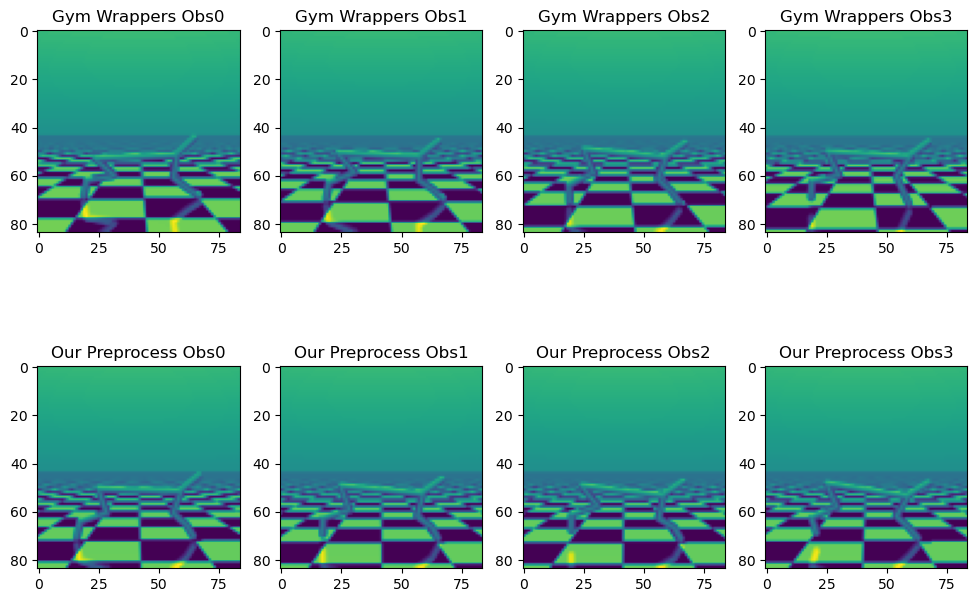

(4, 84, 84)
(4, 84, 84)


In [241]:
import matplotlib
import matplotlib.pyplot as plt

gym_obs = experiment(env1)
our_obs = experiment(env2)

plt.figure(figsize=(12, 8)) # 12 inches wide and 6 inch tall
for i in range(4):
    plt.subplot(2,4, i+1)
    plt.imshow(gym_obs[i])
    plt.title(f'Gym Wrappers Obs{i}')

    plt.subplot(2,4, i+5)
    plt.imshow(our_obs[i])
    plt.title(f'Our Preprocess Obs{i}')

plt.show()

print(gym_obs.shape)
print(our_obs.shape)



In [ ]:
from gymnasium.vector import SyncVectorEnv

env_id = "HalfCheetah-v5"
env3 = gym.make(env_id)
print(env3.observation_space.shape[0]) # 17 states total

def create_env_preprocess_func(env_id):
        def _init():
            env = gym.make(env_id, render_mode='rgb_array')
            # Change env to use render observation
            env = AddRenderObservation(env, render_only=True)
            # Add our own preprocess observation 
            env = PreprocessObservation(env)
            # print(env.observation_space)
            # Stack the last 4 frames
            env = FrameStackObservation(env, stack_size=4)
            return env
        return _init

envs = SyncVectorEnv([create_env_preprocess_func(env_id) for _ in range(2)]) 

obs_shape = envs.observation_space.shape[1:]
action_size = envs.action_space.shape[1:][0]
print(obs_shape)
print(action_size)

actor_critic = ActorCriticNet(obs_shape, action_size)
params = actor_critic.state_dict()
# print(params)
for name in params:
    if 'actor.linear' in name: # do only actor and do only
        # if 'actor.layer_norm' not in name:
        print(name) # -> only layers to update

envs.close()


Experiment what happens, when we have vectorized env. lets try 

In [ ]:
import os
import glfw

# Example function to clean up GLFW properly
def close_glfw():
    if glfw.init():
        glfw.terminate()

# Ensure GLFW works correctly (especially on headless setups)
# os.environ["DISPLAY"] = ":0"

def run_experiment():
    env_id = "HalfCheetah-v5"
    num_envs = 2

    def create_env_preprocess_func(env_id):
        def _init():
            env = gym.make(env_id, render_mode='rgb_array')
            # Change env to use render observation
            env = AddRenderObservation(env, render_only=True)
            # Add our own preprocess observation 
            env = PreprocessObservation(env)
            # print(env.observation_space)
            # Stack the last 4 frames
            env = FrameStackObservation(env, stack_size=4)
            return env
        return _init

    envs = SyncVectorEnv([create_env_preprocess_func(env_id) for _ in range(num_envs)]) 

    print(envs.action_space.)
    print(envs.observation_space)
    print(envs.action_space.shape[1:])
    print(envs.observation_space.shape[1:])
    print(envs.action_space.lo)


    envs.close()  # Ensure environments are properly closed
    close_glfw()


# Run the experiment multiple times
# for _ in range(3):
run_experiment()

if glfw.init():
    glfw.terminate()


Box(-1.0, 1.0, (2, 6), float32)
Box(0.0, 1.0, (2, 4, 84, 84), float32)
(6,)
(4, 84, 84)


TypeError: 'Box' object is not subscriptable

Experimenting to see performance of opencv2 and numpy implementations in the Gymansium

In [26]:
import numpy as np
import cv2
import timeit

# Test image
image = np.random.randint(0, 256, (480, 480, 3), dtype=np.uint8)

# NumPy-based grayscale (as in GrayscaleObservation)
def numpy_grayscale(image):
    image = cv2.resize(image, (84, 84), interpolation=cv2.INTER_AREA)
    image = np.sum(np.multiply(image, [0.2125, 0.7154, 0.0721]), axis=-1).astype(np.uint8)
    image = image / 255
    return image

# OpenCV grayscale
def opencv_grayscale(image):# interestinlgy it works much faster when we do RGB2GRAY operation first, then resize
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) 
    image = cv2.resize(image, (84, 84), interpolation=cv2.INTER_AREA)
    image = image / 255
    return  image

# Timing
numpy_time = timeit.timeit(lambda: numpy_grayscale(image), number=1000)
opencv_time = timeit.timeit(lambda: opencv_grayscale(image), number=1000)

print(f"NumPy-based grayscale: {numpy_time:.4f} seconds")
print(f"OpenCV-based grayscale: {opencv_time:.4f} seconds")

NumPy-based grayscale: 1.1600 seconds
OpenCV-based grayscale: 0.9875 seconds
